In [1]:
%autosave 60
%pip install --quiet -r requirements.txt

Autosaving every 60 seconds
Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_loader import DataLoader
from utils.data_converter import DataConverter
from utils.data_analyser import DataAnalyser
from models.unet_3d_std import ResidualUNet3D
from utils.train_eval import fit_3D
from utils.loss_functions import ssim_loss

data_loader = DataLoader()
data_converter = DataConverter()
data_analyser = DataAnalyser()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Flush cuda memory

In [3]:
torch.cuda.empty_cache()

Common Variables

In [4]:
model_epochs            = 2500
save_every              = 250
model_checkpoint_every  = 100

In [5]:
training_pairs, validation_pairs, test_pairs = data_loader.split_dataset_paths(seed=69) # Standard 70/20/10 split
print("We have", len(training_pairs), "training pairs")
print("We have", len(test_pairs), "test pairs")

We have 492 training pairs
We have 106 test pairs


## 3D U-Net

In [6]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [7]:
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

Loading existing model
492 training pairs


In [8]:
unet, unet_losses, unet_snapshots, unet_best = fit_3D(
    model=unet,
    device=device,
    training_pairs=training_pairs,
    validation_pairs=validation_pairs,
    epochs=model_epochs,
    loss_func=ssim_loss,
    dataConverter=data_converter,
    optimizer=unet_optimizer,
    save_every=save_every,
    checkpoint_every=model_checkpoint_every,
    crop_axes=((16, 10, 0), (17, 11, 17)),
)

Training 3D Residual U-Net:   0%|          | 0/2500 [00:00<?, ?it/s]

Training 3D Residual U-Net: 100%|██████████| 2500/2500 [49:28<00:00,  1.19s/it, Best loss on val 0.552415, (Iter 1300)]  


Displaying snapshot from pair 0, loss: 0.0676


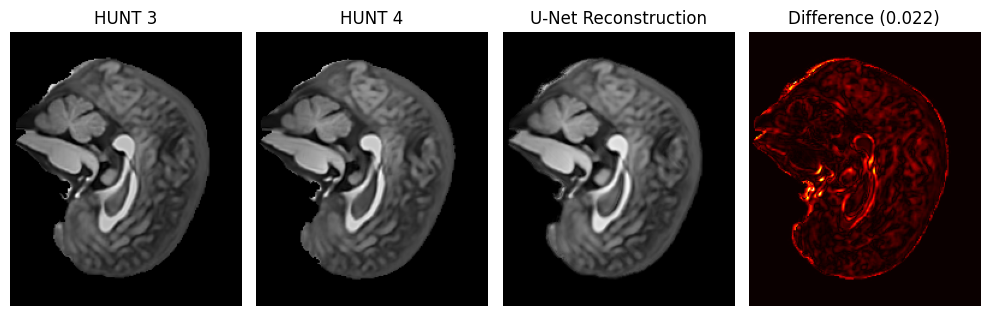

Displaying snapshot from pair 250, loss: 0.0870


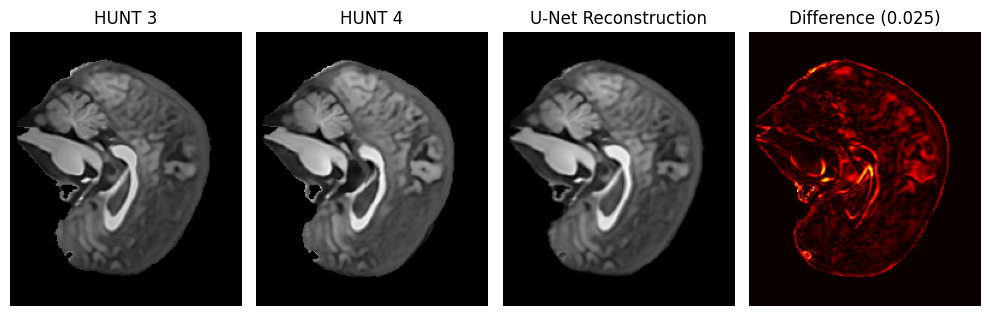

Displaying snapshot from pair 500, loss: 0.0761


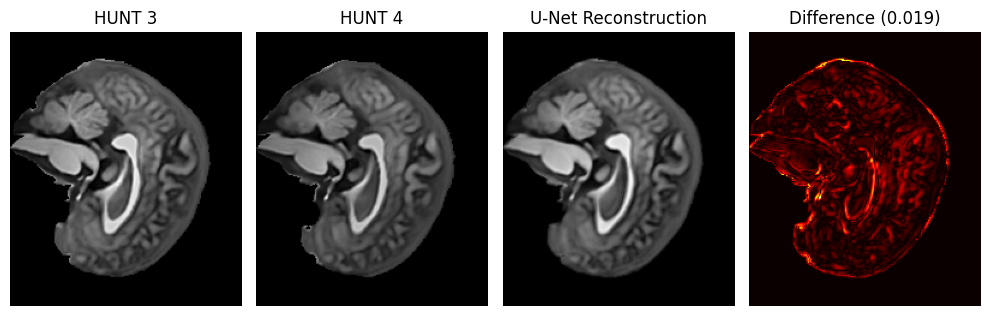

Displaying snapshot from pair 750, loss: 0.0658


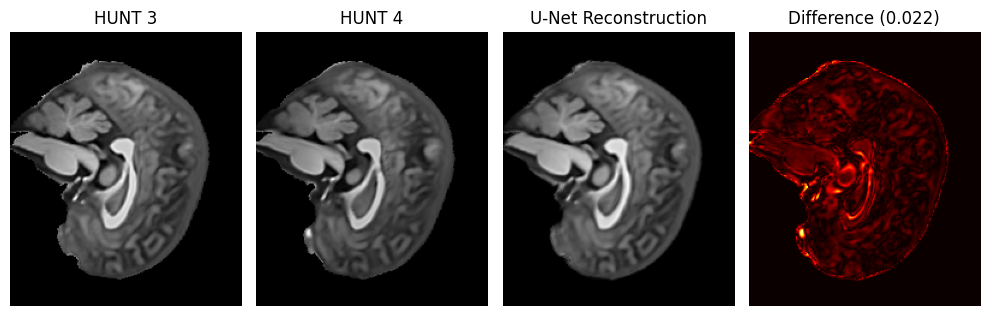

Displaying snapshot from pair 1000, loss: 0.0702


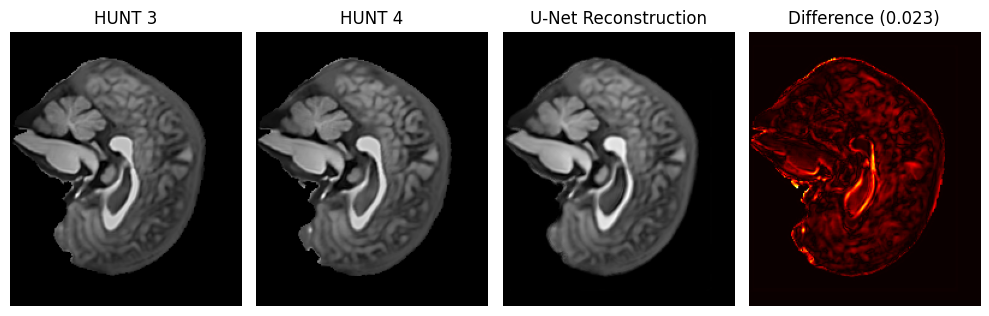

Displaying snapshot from pair 1250, loss: 0.0737


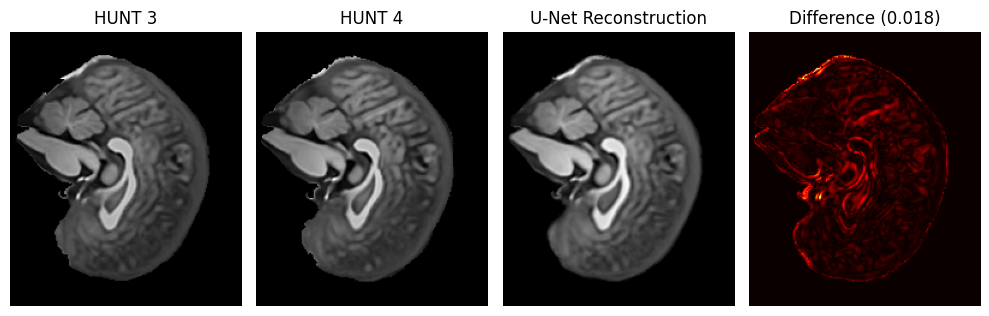

Displaying snapshot from pair 1500, loss: 0.0751


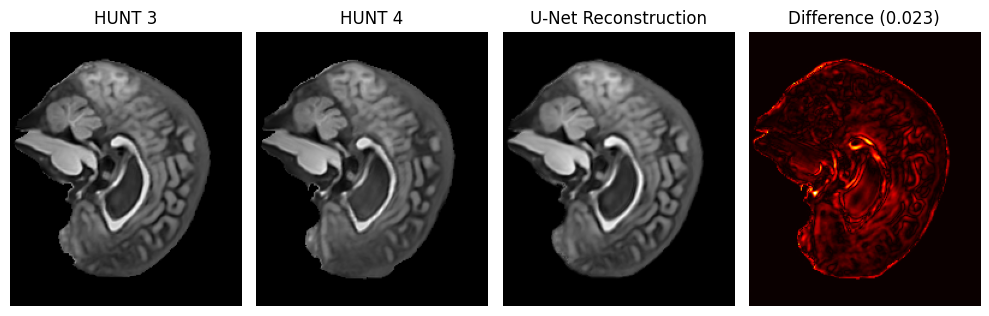

Displaying snapshot from pair 1750, loss: 0.0651


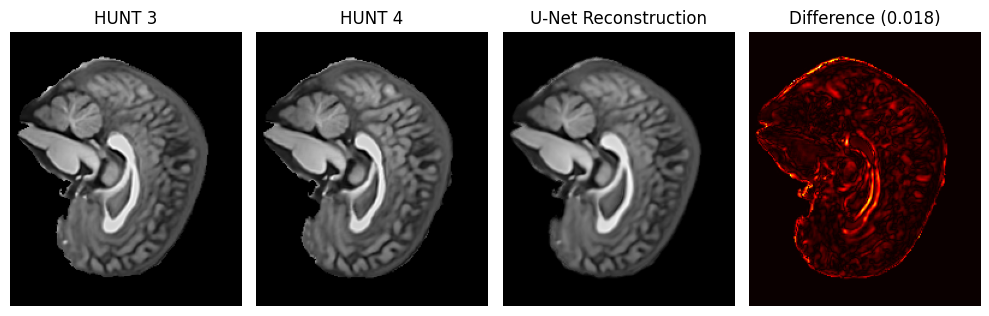

Displaying snapshot from pair 2000, loss: 0.0604


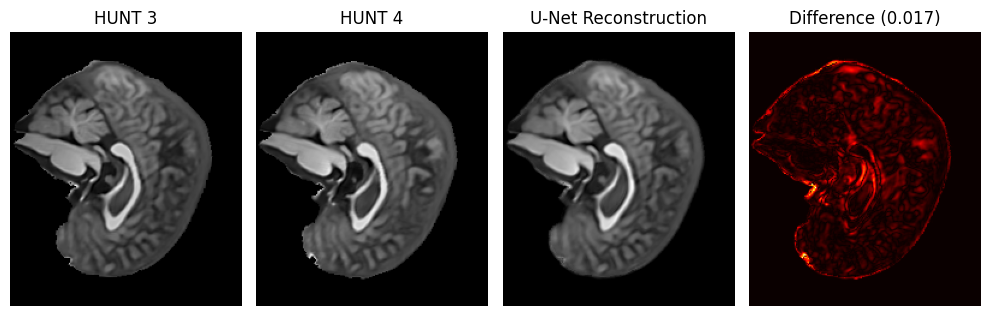

Displaying snapshot from pair 2250, loss: 0.0810


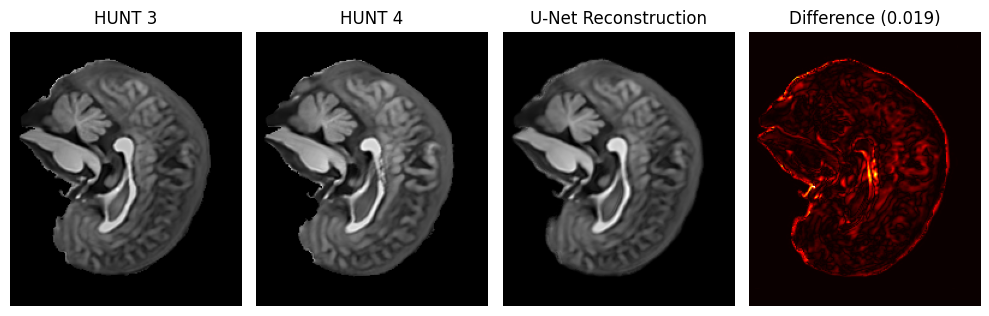

Displaying snapshot from pair 2499, loss: 0.0692


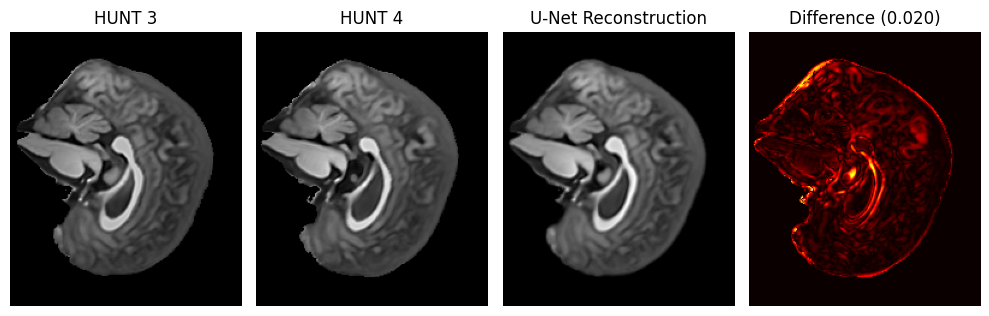

In [9]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_analyser.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [10]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unets/3d_unet_model_standard.pt


## Estimate Accuracy over testset

In [11]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"

# Import model before testing
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet.load_state_dict(torch.load(unet_path))
print("Loaded trained model for testing.")

Loaded trained model for testing.


In [ ]:
unet.eval()

avg_unet_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input, target = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    
    # Get Reconstructions
    unet_recon = unet(input)[0]

    # calculate 3d loss
    avg_unet_loss += ssim_loss(unet_recon, target).item()

avg_unet_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")

# We save the model with the test loss in the filename for easy identification
test_unet_path = f"{output_dir}/3d_unet_model_standard_testloss_{avg_unet_loss:.4f}.pt"
torch.save(unet.state_dict(), test_unet_path)
print(f"Test model saved to {test_unet_path}")

100%|██████████| 106/106 [00:55<00:00,  1.93it/s]

Average U-Net 3D Loss over Test Set: 0.5587


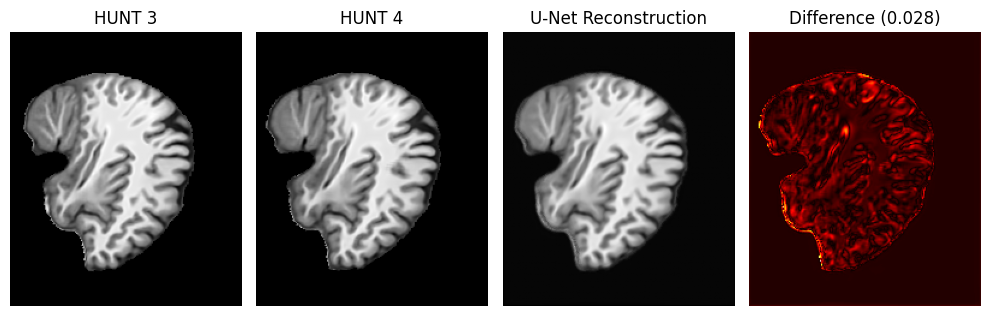

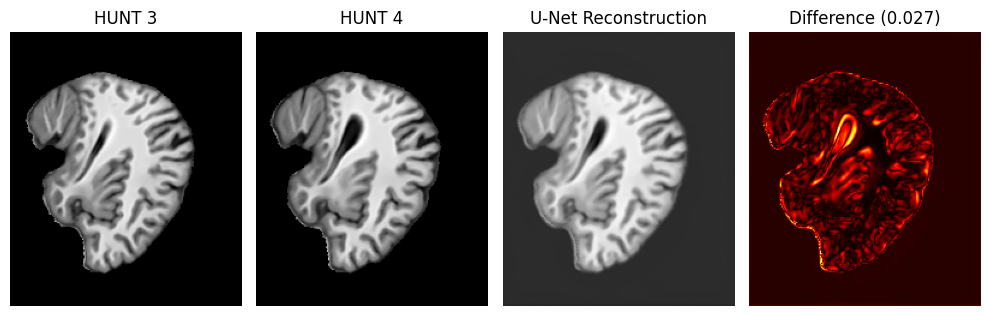

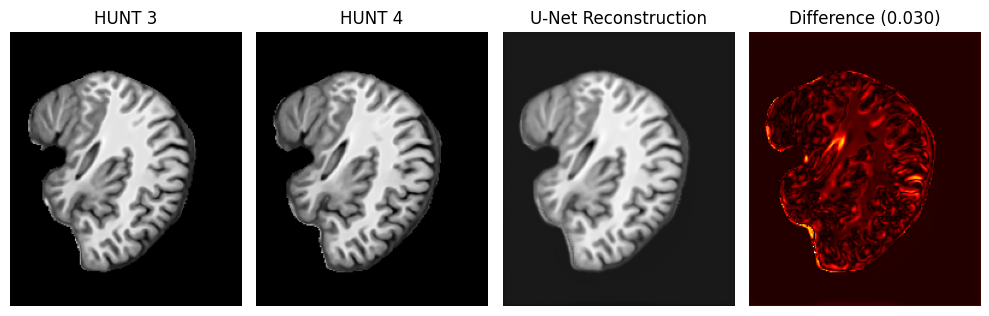

In [13]:
# Display some test results
num_display = 3
slice_position = 60

for i in range(num_display):
    input_path, target_path = random.choice(test_pairs)
    input, target = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    unet_recon = unet(input)[0].detach().cpu().numpy().squeeze()[slice_position]
    x = input[0,0].detach().cpu().numpy()[slice_position]
    y = target[0,0].detach().cpu().numpy()[slice_position]
    difference = np.abs(unet_recon - y)
    data_analyser.display_slices([x, y, unet_recon, difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])